In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
from pandas.api.indexers import FixedForwardWindowIndexer
from matplotlib.ticker import PercentFormatter

import jax
import jax.numpy as np
from jax.numpy import array as arr
from jax import lax, random
from jax.experimental.ode import odeint
from jax.scipy.special import logsumexp
from jax.scipy.special import expit as logistic
from jax.scipy.special import logit
from jax.scipy.special import gammaln
from jax.scipy import stats

import numpyro as pn
from numpyro import sample
from numpyro import deterministic
import numpyro.distributions as dist
from numpyro.distributions import Normal as Norm
from numpyro.distributions import Exponential as Ex
from numpyro.distributions import Poisson as Pois
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import print_summary, hpdi

from scipy.interpolate import BSpline
import numpy as num ##scipy needs actual numpy

import warnings
import dill

/Users/sasha/miniconda3/envs/sero/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri May 31 2024

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.14.0

matplotlib: 3.7.1
arviz     : 0.12.1
jax       : 0.3.17
dill      : 0.3.6
numpyro   : 0.10.1
pandas    : 1.4.4
seaborn   : 0.12.2
numpy     : 1.25.0

Watermark: 2.3.1



In [3]:
%config InlineBackend.figure_formats = ["svg"]
plt.style.use("default")
sns.set_theme(context='paper', style="ticks", font_scale=1.25)
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(category.__name__, message)

## set numpyro platform to cpu because I don't have the right kind of gpu
pn.set_platform("cpu")

## tell numpyro to use mult cpu cores (this many chains can run in parallel)
pn.set_host_device_count(4)

## jax wants float32's by default, but sometimes it helps to use higher-precision floats:
HIPREC = True

if HIPREC: 
    pn.enable_x64()
    fl = np.float64
    toint = np.int64
else:
    fl = np.float32
    toint = np.int32

## for jax's RNG
def key_gen(seed = random.PRNGKey(8927)):
    def key():
        nonlocal seed
        seed, new_key = random.split(seed)
        return new_key
    return key

key = key_gen()


In [4]:
def store(obj, name):
    with open(f'{name}.dill', 'wb') as f:
        dill.dump(obj, f)

def load(name):
    with open(f'{name}.dill', 'rb') as f:
        return dill.load(f)

def pdz(series):
    return (series - series.mean()) / series.std()

## resizes an array, repeating the last element if needed
def resize(x, new_size):
    return np.concatenate([x,np.repeat(x[-1], max(0,new_size-len(x)))])[:new_size]


In [5]:
def SECIR_ode(y, t, p):
    S, E, C, I, R, CumC, CumI = y[0], y[1], y[2], y[3], y[4], y[5], y[6]
    alpha, beta, mu, gamma1, gamma2, theta = p[0], p[1], p[2], p[3], p[4], p[5]
    N = S + E + C + I + R
    S_dot = -S*C*alpha*beta/N - S*I*beta/N
    E_dot = S*C*alpha*beta/N + S*I*beta/N - E*mu
    C_dot = E*mu*(1-theta) - C*gamma1
    I_dot = E*mu*theta - I*gamma2
    R_dot = C*gamma1 + I*gamma2
    CumC_dot = E*mu*(1-theta)
    CumI_dot = E*mu*theta
    return np.stack([S_dot, E_dot, C_dot, I_dot, R_dot, CumC_dot, CumI_dot])

In [6]:
## have to do time-variable ODE params this way
##  then, jax.lax.scan(onestep, y0, p_t)[1]
## scan() will pass each param set in p_t to onestep() and collect the results in return value [1]
## p_t must have time as the first axis
def onestep(prev, p):
    next = odeint(SECIR_ode, prev, arr([0.,1.]), p, rtol=1e-6, atol=1e-6, mxstep=2000)#rtol=1e-6, atol=1e-6, mxstep=1000)#rtol=1e-5, atol=1e-5, mxstep=500)
    return next[1], next[1]

In [7]:
## this way works fine by itself, but not inside the sampler
##  for some incomprehensible reason
def SECIR_ode_t(y, t, p):
    S, E, C, I, R, CumC, CumI = y[0], y[1], y[2], y[3], y[4], y[5], y[6]
    idx = toint(t)
    alpha, beta, mu, gamma1, gamma2, theta = p[0][idx], p[1][idx], p[2][idx], p[3][idx], p[4][idx], p[5][idx]
    N = S + E + C + I + R
    S_dot = -S*C*alpha*beta/N - S*I*beta/N
    E_dot = S*C*alpha*beta/N + S*I*beta/N - E*mu
    C_dot = E*mu*(1-theta) - C*gamma1
    I_dot = E*mu*theta - I*gamma2
    R_dot = C*gamma1 + I*gamma2
    CumC_dot = E*mu*(1-theta)
    CumI_dot = E*mu*theta
    return np.stack([S_dot, E_dot, C_dot, I_dot, R_dot, CumC_dot, CumI_dot])

In [8]:
## R = (th)(b / g2) + (a)(1-th)(b / g1)

## R*g1*g2 =  b * [ th*g1 + a(1-th)*g2 ] 

## b = R*g1*g2 / [ th*g1 + a(1-th)*g2 ]

def calc_R(b, g1, g2, th, a = 1.0):
    return th*(b / g2) + a*(1.0-th)*(b / g1)

def calc_b(R, g1, g2, th, a = 1.0):
    return R*g1*g2 / ( th*g1 + a*(1.0-th)*g2 )

In [9]:

def pred_daily_samp(post, modeldict, n_draws, full_reporting=False):
    res = []
    psize = modeldict['Population']
    nsamples = post['sigma'].shape[0]
    samp_ids = jax.random.permutation(key(),nsamples,independent=True)[:n_draws]
    for s in samp_ids:
        b0, th0 = post['beta'][s], post['theta'][s]
        if full_reporting:
            th0 = np.ones_like(th0)
        a0,mu0,g1,g2 = post['alpha'][s], post['mu'][s], post['gamma1'][s], post['gamma2'][s]
        e0,i0,c0 = post['e0'][s], post['i0'][s], post['c0'][s]
        y0 = arr([psize - (e0 + c0 + i0), e0, c0, i0, c0*0.0, c0, i0])
        p_t = np.stack([a0 , b0 , mu0 , g1, g2, th0]).T #time first
        pred_vals = jax.lax.scan(onestep, y0, p_t)[1]
        pred_daily = np.diff(pred_vals[:,6], prepend=0)
        res.append(pred_daily)

    return np.stack(res)


In [10]:
def df_samples(post, modeldict, real_R_calc = False):
    df = pd.DataFrame({"Date":modeldict["Dates"]})

    if real_R_calc:
        R_t = calc_R(post['beta'], post['gamma1'], post['gamma2'], post['theta'], post['alpha'])
    else:
        R_t = post['beta'] / post['gamma2']

    df["R_t"] = R_t.mean(0)
    ci = hpdi(R_t)
    df["R_t_lower95"] = ci[0,:]
    df["R_t_upper95"] = ci[1,:]
    df['DailyCases'] = modeldict['DailyCases']
    df['theta'] = post['theta'].mean(0)
    cols = []
    pred_daily = pred_daily_samp(post, modeldict, 50)
    for i,v in enumerate(pred_daily):
        colname = 'sim'+str(i)
        df[colname] = v
        cols.append(colname)

    return df, cols

In [11]:
def df_beta(post, modeldict, real_R_calc = False):
    df = pd.DataFrame({"Date":modeldict["Dates"]})

    if real_R_calc:
        R_t = calc_R(post['beta'], post['gamma1'], post['gamma2'], post['theta'], post['alpha'])
    else:
        R_t = post['beta'] / post['gamma2']

    df["R_t"] = R_t.mean(0)
    ci = hpdi(R_t)
    df["R_t_lower95"] = ci[0,:]
    df["R_t_upper95"] = ci[1,:]
    df['beta_model'] = post['beta_ex'].mean(0)
    df['beta_err'] = post['beta_err'].mean(0)
    ci_ex = hpdi(post['beta_ex'])
    ci_err = hpdi(post['beta_err'])
    df['beta_model_lower95'] = ci_ex[0,:]
    df['beta_model_upper95'] = ci_ex[1,:]
    df['beta_err_lower95'] = ci_err[0,:]
    df['beta_err_upper95'] = ci_err[1,:]
    df['theta'] = post['theta'].mean(0)
    ci_th = hpdi(post['theta'])
    df['theta_lower95'] = ci_th[0,:]
    df['theta_upper95'] = ci_th[1,:]
    df['DailyCases'] = modeldict['DailyCases']
    cols = []
    pred_daily = pred_daily_samp(post, modeldict, 50)
    for i,v in enumerate(pred_daily):
        colname = 'sim'+str(i)
        df[colname] = v
        cols.append(colname)
    df['mean_sim'] = df[cols].mean(axis=1)
    return df, cols

In [12]:
## data from MD dept of health
MD_cases_all = pd.read_csv("MDCOVID19_TotalCasesStatewide.csv")
MD_cases_all["daily"] = np.diff(MD_cases_all["Count_"].values, prepend=0)

## forward-looking moving average, because reporting is always in the future
f7_indexer = FixedForwardWindowIndexer(window_size=7)

MD_cases_all["MD_DailyCases"] = MD_cases_all["daily"].rolling(f7_indexer, min_periods=1).mean()
MD_cases_all["Date"] = MD_cases_all["DATE"].apply(lambda x: str.split(x)[0].replace('/','-'))
MD_cases = MD_cases_all.loc[0:453,["Date","MD_DailyCases"]].copy(deep=True)
MD_cases

,Date,MD_DailyCases
0,2020-03-04,1.285714
1,2020-03-05,1.714286
2,2020-03-06,1.285714
3,2020-03-07,1.714286
4,2020-03-08,3.285714
...,...,...
449,2021-05-27,168.857143
450,2021-05-28,157.000000
451,2021-05-29,142.285714
452,2021-05-30,134.714286


In [13]:
bad_MD = MD_cases["MD_DailyCases"] < 0.0
MD_cases.loc[bad_MD,"MD_DailyCases"] = np.nan
md_data_ok = np.logical_not(bad_MD.values)
bad_MD.sum()

0

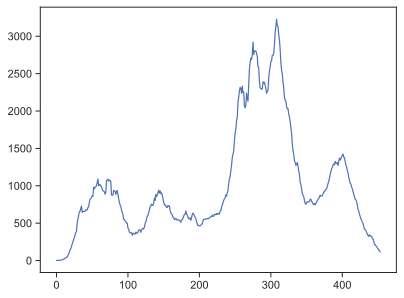

In [14]:
plt.plot(MD_cases["MD_DailyCases"]);

In [15]:
## serology data from JHU
sero_results = pd.read_csv('TestResultsByDateWithWeights.csv')
## overall weight of each data point
sero_results['wt'] = sero_results['hwght'] * sero_results['psuweight']
sero_results['weight'] = (sero_results["wt"] / sero_results["wt"].mean())
sero_results['dt'] = pd.to_datetime(sero_results['Specimen_collection_date']).apply(str)
sero_results['Date'] = sero_results['dt'].apply(lambda x: str.split(x)[0].replace('/','-'))
## match date index to case data
date_idxs = pd.DataFrame({"Date":MD_cases["Date"], "date_idx":range(len(MD_cases["Date"]))})
sero_results = sero_results.merge(date_idxs,how="left",on="Date")

## assume 14 days from symptom onset to seroconversion
## map each sero result to the infection count from 14 days prior
sero_results["date_idx"] = sero_results["date_idx"] - 14

sero_results = sero_results[["Date","date_idx","seropos","weight"]]
sero_results = sero_results.sort_values(by="date_idx")
sero_results

,Date,date_idx,seropos,weight
4310,2020-08-12,147,0,0.287750
4313,2020-08-12,147,0,0.326502
4312,2020-08-12,147,0,0.326502
4311,2020-08-12,147,0,0.412858
4296,2020-08-12,147,0,0.326502
...,...,...,...,...
5860,2020-12-07,264,0,0.481681
5858,2020-12-07,264,1,0.600684
5857,2020-12-07,264,0,0.917738
5874,2020-12-07,264,0,0.481681


In [16]:
## MD deaths from dept health
dd = pd.read_csv('MDCOVID19_TotalConfirmedDeathsByDateOfDeath.csv')
dd['Date'] = dd['DATE'].apply(lambda x: str.split(x)[0].replace('/','-'))
MD_deaths = MD_cases[["Date"]].merge(dd[["Date","Count_"]],how="outer",on="Date").fillna(0.0)
## forward-looking moving average, because reporting is always in the future
MD_deaths['daily_deaths']  = MD_deaths["Count_"].rolling(f7_indexer, min_periods=1).mean()
MD_deaths = MD_deaths[["Date","daily_deaths"]]
MD_deaths.set_index('Date',verify_integrity=True,inplace=True)
MD_deaths

,daily_deaths
Date,
2020-03-04,0.000000
2020-03-05,0.000000
2020-03-06,0.000000
2020-03-07,0.000000
2020-03-08,0.000000
...,...
2022-11-13,2.000000
2022-11-14,2.000000
2022-11-15,1.666667


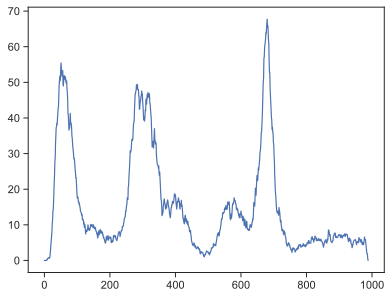

In [17]:
plt.plot(MD_deaths['daily_deaths'].values);

In [18]:
def read_mobility_data():
    # google movement data
    ##
    ## from: https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip
    ##
    gdat = pd.concat([pd.read_csv(str(y)+'_US_Region_Mobility_Report.csv', dtype={'census_fips_code':str}) 
            for y in [2020, 2021, 2022]])

    gdat_tmp = gdat.copy(deep=True)
    # natural scale where 1 = baseline
    gdat_tmp['RR'] = 1.0 + gdat_tmp['retail_and_recreation_percent_change_from_baseline'] / 100.0
    gdat_tmp['GP'] = 1.0 + gdat_tmp['grocery_and_pharmacy_percent_change_from_baseline'] / 100.0
    gdat_tmp['TS'] = 1.0 + gdat_tmp['transit_stations_percent_change_from_baseline'] / 100.0
    gdat_tmp['WP'] = 1.0 + gdat_tmp['workplaces_percent_change_from_baseline'] / 100.0
    gdat_tmp['RES'] = 1.0 + gdat_tmp['residential_percent_change_from_baseline'] / 100.0
    gdat_tmp['PARK'] = 1.0 + gdat_tmp['parks_percent_change_from_baseline'] / 100.0
    gdat_tmp['mvmean'] = gdat_tmp[['RR','GP','TS','WP']].mean(axis=1) ##for now, assuming these 4 contribute equally
    ## only the columns we need
    gdat_tmp['county'] = gdat_tmp['census_fips_code']
    gdat_tmp = gdat_tmp.loc[~gdat_tmp['county'].isna(),['county','date','mvmean','RR','GP','TS','WP','RES','PARK']].copy(deep=True)

    ## just the means by county and date
    county_mvmean_all = gdat_tmp.pivot(index='county',columns='date',values='mvmean').sort_index().copy(deep=True)
    ## impute the missing values along date axis
    county_mvmean_all.interpolate(method='linear',axis=1,inplace=True)

    ## weight movement by population
    county_pops_all = pd.read_csv("location_pops.csv")
    county_pops_all.sort_values(by=['location'],ignore_index=True,inplace=True)
    county_pops_all.set_index('location',verify_integrity=True,inplace=True)
    county_pops_all.sort_index(inplace=True)
    county_pops_subset = county_pops_all.loc[county_pops_all.index.isin(county_mvmean_all.index)]
    county_mv_wt_all = (county_mvmean_all.T * county_pops_subset['population']).T

    ## just maryland counties
    mddcva = pd.read_csv('MDDCVACountyToZip.csv', dtype={0:str,1:str,2:str,3:str,4:str})
    mdcounties = mddcva.loc[mddcva.STATE == 'MD', mddcva.columns[[1,3]]]
    mdcounties = mdcounties.drop_duplicates().set_index('STCOUNTYFP', verify_integrity=True).sort_index()
    MD_mv_wt = county_mv_wt_all[county_mv_wt_all.index.isin(mdcounties.index)].copy(deep=True)
    ## total maryland movement normalized by pop
    MD_mvmean = MD_mv_wt.sum(axis=0) / county_pops_subset.loc[county_pops_subset.index.isin(mdcounties.index), "population"].sum()
    return MD_mvmean

In [19]:
def read_humidity_data():
    # humidity data
    hdat = pd.read_csv('Humidity_State.csv')
    MD_humid_raw = hdat[hdat['STATE']=='MD'].set_index('DATE',verify_integrity=True).sort_index().loc[:,['AH_mean','AH_min','AH_max']].copy(deep=True)
    ## standardize humidity to make params/priors easier to think about
    MD_humid_raw['AH_scaled'] = MD_humid_raw['AH_mean'] / MD_humid_raw['AH_mean'].mean()
    MD_humid_raw['AH_z'] = pdz(MD_humid_raw['AH_mean'])
    MD_humid_raw['AH_log'] = MD_humid_raw['AH_mean'].map(num.log)
    MD_humid_raw['AH_log_z'] = pdz(MD_humid_raw['AH_log'])
    return MD_humid_raw



In [20]:
## daily incident hospitalizations
def read_hosp_data():
    ## this data is from healthdata.gov, MD starts 7/14/20
    h_daily = pd.read_csv('truth-Incident Hospitalizations.csv')
    h_daily_md_from0714 = h_daily[h_daily.location_name == 'Maryland'].set_index('date',verify_integrity=True).sort_index()['value']

    ## this data is from MD dept of health, 3/13/20 to 12/04/21
    hosp_gov = pd.read_csv('MDCOVID19_TotalHospitalizations.csv')
    hosp_gov = hosp_gov.loc[0:631]
    hosp_gov.fillna(method='ffill', inplace=True)
    hosp_gov['daily'] = arr( [2.0, *(hosp_gov['Count_'].values[1:] - hosp_gov['Count_'].values[:-1])] )
    hosp_gov['date_formatted'] = hosp_gov['DATE'].apply(lambda x: str.split(x)[0].replace('/','-'))
    hosp_gov.set_index('date_formatted',verify_integrity=True,inplace=True)
    hosp_gov.sort_index(inplace=True)
    h_daily_md_0313to0713 = hosp_gov.iloc[0:123]['daily']

    date_prepend = pd.date_range("2020-02-15","2020-03-12",freq="D").strftime("%Y-%m-%d")
    zeros_prepend = np.zeros(len(date_prepend)) ## assume 0 before first reported

    MD_h_daily_unsmoo = pd.DataFrame({'date': [*date_prepend, *hosp_gov.index[0:123], *h_daily_md_from0714.index], 
    'daily_hosp':np.concatenate([zeros_prepend, fl(arr(h_daily_md_0313to0713)), fl(arr(h_daily_md_from0714))])})

    MD_h_daily_unsmoo.set_index('date',verify_integrity=True,inplace=True)
    return MD_h_daily_unsmoo


In [21]:
date_index = pd.Index(MD_cases["Date"])

In [22]:
s_mob_rel_a = read_mobility_data().rolling(14).mean() ## 14 day MA

## reset "baseline" movement to its mean during pandemic
## -- makes priors easier to think about
s_mob_rel_a = s_mob_rel_a / s_mob_rel_a.mean()
## squared mobility to approximate mobility-contact rate relationship
s_mob_sq_a = s_mob_rel_a ** 2.0

## note: standardize before subsetting
s_mob_rel = s_mob_rel_a.loc[date_index]
s_mob_sq = s_mob_sq_a.loc[date_index]

In [23]:
df_humid = read_humidity_data().rolling(14).mean() ## 14 day MA
df_humid = df_humid.loc[date_index]


In [24]:
MDpop = 6177224.0 ## from US census ## 6045680.0, ## from ???

In [25]:
## base behavior on projected hospitalizations
ma = 14
lookback = [3, 6, 9, 12]
planning = 5

MD_h_daily_unsmoo = read_hosp_data()

## un-centered MA to smoothe reporting noise and create information lag
h_df = MD_h_daily_unsmoo.rolling(ma,center=False).mean().copy(deep=True)

## add 1 to drown out small-number noise at the beginning
h_df['logH'] = np.log(1.0 + h_df['daily_hosp'].values)

for x in lookback:
    h_df['r'+str(x)] = h_df['logH'].diff(x) / fl(x)
h_df['rmean'] = h_df[['r'+str(x) for x in lookback]].mean(axis=1)

for x in range(planning+1):
    h_df['H_e'+str(x)] = np.exp(arr(h_df['logH'] + fl(x) * h_df['rmean']))
h_df['H_proj'] = h_df[['H_e'+str(x) for x in range(planning+1)]].sum(axis=1)

proj_cases = arr(h_df.loc[date_index,'H_proj'])
p_infection = proj_cases / MDpop


In [26]:
daily_obs = arr(MD_cases['MD_DailyCases'].values)
ts = np.arange(fl(len(daily_obs)))
daily_ok_raw = daily_obs[md_data_ok]
totalI = np.sum(daily_ok_raw)

In [27]:
## splines
## evenly spaced basis splines, approx 14 day period
n_spline_periods = 32 
deg = 2
knots = num.linspace(0., ts.max(), n_spline_periods+1-deg)
padded_knots = num.pad(knots, (deg,deg), mode='edge')
B = BSpline(padded_knots, num.identity(len(knots)+deg-1), deg)(ts)

In [28]:
MD_dict = {
    'tdom': ts,
    'Dates': MD_cases["Date"].values,
    'initInfected': 1.0, ## I compartment only; C compartment estimated by model
    'Population': MDpop,
    'alpha': np.repeat(1.0, len(ts)),
    'mu': np.repeat(0.15, len(ts)), ## incubation 6.65 days ref Wu 2022
    'gamma1': np.repeat(0.2, len(ts)), ## infectiousness period ~5 days ref Bi 2020 and Giardina 2021
    'gamma2': np.repeat(0.2, len(ts)),
    'DailyCases': daily_obs,
    'totalI': totalI,
    'daily_ok': daily_ok_raw / totalI,
    'Nt': len(daily_ok_raw),
    'knots': arr(knots),
    'spline': arr(B),
    'nperiods': n_spline_periods,
    'sero_date_idxs': arr(sero_results["date_idx"].values),
    'seropos': arr(sero_results["seropos"].values),
    'sero_weights': arr(sero_results["weight"].values),
    'mvmean_sq0': arr(s_mob_sq - 1.0), ## squared, then centered on 0
    'AH_log_z': arr(df_humid['AH_log_z']),
    'p_infection': p_infection,
    'behav_delay': 20
}

ok_for_jax = md_data_ok

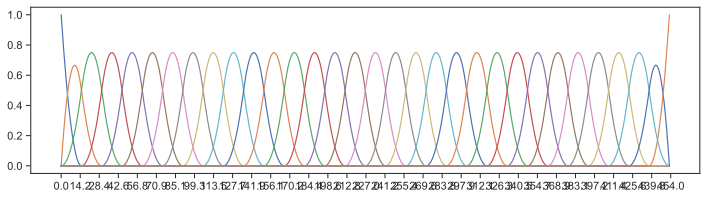

In [29]:
## the splines:
_,ax = plt.subplots(figsize=[12,3])
ax.set_xticks(np.linspace(0,len(MD_dict['tdom']),MD_dict['nperiods']+1))
for i in range(MD_dict['nperiods']):
    plt.plot(MD_dict['spline'][:,i])

(454,)

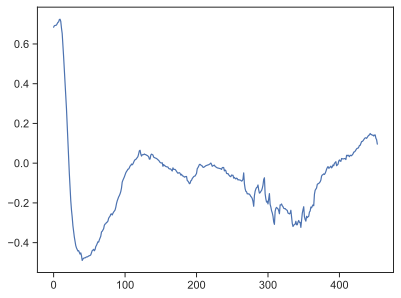

In [30]:
plt.plot(MD_dict['mvmean_sq0'])
MD_dict['mvmean_sq0'].shape

(454,)

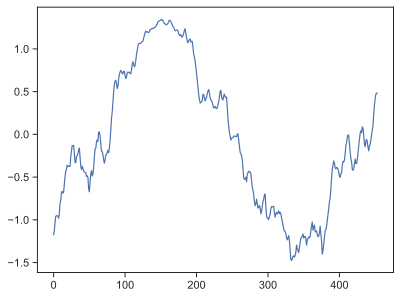

In [31]:
plt.plot(MD_dict['AH_log_z'])
MD_dict['AH_log_z'].shape

(454,)

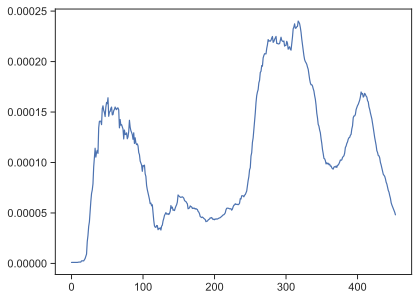

In [32]:
plt.plot(MD_dict['p_infection'])
MD_dict['p_infection'].shape

In [33]:
##
## beta is modeled by splines only
##
## prior for beta is set such that R is roughly centered around 1 while still allowing values > 4
## if alpha or gamma changes, relationship btw R and beta changes
## -- set beta_prior_exp to a value that gives R = 1
##
def model_wrev(mdict, data_ok, beta_prior_exp = 0.2):

    alpha = deterministic("alpha", mdict['alpha'])
    mu = deterministic("mu", mdict['mu'])
    gamma2 = deterministic("gamma2", mdict['gamma2'])
    gamma1 = deterministic("gamma1", mdict['gamma1'])

    ## gamma(2,5) prior ## (ref Karimizadeh 2023)
    beta_conc = 5.0 #9.0 
    beta_n = 1.0 + beta_prior_exp * beta_conc #1.0 + beta_prior_exp * (1.0 + beta_conc)

    #using basis splines for beta
    beta_mean = sample("beta_mean", dist.Gamma(beta_n,beta_conc), sample_shape=(mdict['nperiods'],))
    beta = deterministic("beta", mdict['spline'] @ beta_mean)
    
    ## generalized logistic for theta
    th0 = sample("th0", Norm(logit(0.1), 4.0))
    #th_min = sample("th_min", dist.Beta(0.20,2.0))
    dth_dt = sample("dth_dt", dist.HalfNormal(0.2)) ##constrain to be increasing
    th_max = sample("th_max", dist.Beta(2.0,2.0))
    #th_x0 = sample("th_x0", dist.Gamma(3.0,0.1))
    #th_shape = sample("th_shape", dist.LogNormal(0.0,0.7))
    theta = deterministic("theta", th_max * logistic(th0 + mdict['tdom']*dth_dt))
    #theta = deterministic("theta", th_min + (th_max - th_min) * logistic(dth_dt * (mdict['tdom'] - th_x0 )) )
    #theta = deterministic("theta", th_max * np.power(1.0 + np.exp(-th0 - mdict['tdom']*dth_dt), -th_shape))

    i0 = deterministic("i0", mdict['initInfected'])
    e0 = deterministic("e0", 0.0)
    ## c0 should be approx i0/theta
    #c0 = deterministic("c0", i0 / theta[0])
    log_init = sample("log_init", Norm(4.0, 4.0)) ##helps sampling to leave c0 free
    c0 = deterministic("c0", np.exp(log_init))
    psize = mdict['Population']
    y0 = np.stack([psize - (e0 + i0 + c0), e0, c0, i0, 0.0, c0, i0])

    p_t = np.stack([alpha, beta, mu, gamma1, gamma2, theta]).T #transpose so time is first axis
    pred_vals = jax.lax.scan(onestep, y0, p_t)[1] #see explanation in onestep() above
    pred_daily = np.diff(pred_vals[:,6], prepend=0)
    pred_ok = pred_daily[data_ok] / mdict['totalI']

    ## seroreversion (time from seroconversion): Weibull shape 2.32, scale 202.20 (Brazeau et al 2022)
    #rev_k = sample("rev_k", dist.Gamma(9.28,4.0)) # Norm(2.32, 1.0))
    rev_k = deterministic("rev_k", 2.32) ## assume fixed? (1 = exponential dist)
    rev_L = sample("rev_L", Norm(202.20, 10.0))
    ## if using non-fixed k, parameterize using mean instead of scale (easier priors)
    #rev_mean = sample("rev_mean", Norm(179.15, 20.0))
    #rev_L = np.maximum(1e-6, rev_mean / np.exp(gammaln(1.0 + 1.0 / rev_k)) )

    ## precompute reversion curves for each day in the testing period
    rev_curve = np.flip(np.exp(-np.power( np.arange(300.) / rev_L, rev_k)))
    rev_mat = np.flip( jax.lax.map(lambda i: np.roll(rev_curve,i), -1*np.arange(300)) , axis=0 ) * np.tri(300)
    ## p detectable as function of time (days)
    true_p_inf = mdict["DailyCases"][:300] / (theta[:300] * psize)
    detectable_by_day = np.nansum(true_p_inf * rev_mat , axis=1)

    ## p = detectable_by_day[MD_dict["sero_date_idxs"]]
    ## obs = MD_dict["seropos"]
    ## weights = MD_dict["sero_weights"]
    with pn.plate("sero_data", len(MD_dict["seropos"])), pn.handlers.scale(scale=MD_dict["sero_weights"]):
        sample("sero", dist.Bernoulli(detectable_by_day[MD_dict["sero_date_idxs"]]), obs=MD_dict["seropos"])

    sigma = sample("sigma", dist.Exponential(1.0))
    nu = sample("xnu", dist.Gamma(4.0,1.0)) ## df should be < 10 for robustness
    #nu = 5.0 ## fixed for now
    #sample("daily", dist.StudentT(nu, pred_ok, sigma), obs=mdict['daily_ok'])
    eps = 1.0 / psize
    sample("daily", dist.StudentT(nu, np.log(eps+pred_ok), sigma), obs=np.log(eps+mdict['daily_ok']))


In [34]:
##
## beta is modeled as a linear function of mobility and humidity
##
##  intercept (ba) does not make much difference in this model
##  but keeping the calculation to be consistent with the spline-only model

def model_mh_linear(mdict, data_ok, beta_prior_exp = 0.2):

    sigma = sample("sigma", dist.Exponential(1.0))

    alpha = deterministic("alpha", mdict['alpha'])
    mu = deterministic("mu", mdict['mu'])
    gamma2 = deterministic("gamma2", mdict['gamma2'])
    gamma1 = deterministic("gamma1", mdict['gamma1'])

    #using basis splines for unexplained changes in beta
    ## setting variance on these seems arbitrary
    #err_adj = sigma *  mdict['nperiods'] / mdict['Nt']
    err_adj = 0.01
    z_knots = sample("z_knots", Norm(0.0, 1.0), sample_shape=(mdict['nperiods'],))
    b_err_at_knots = deterministic("b_err_at_knots", err_adj * z_knots)

    ## informative prior for mean beta (using this for the intercept)
    beta_conc = 5.0 ## gamma(2,5) prior ## (ref Karimizadeh 2023)
    beta_n = 1.0 + beta_prior_exp * beta_conc

    ## linear model
    ba = sample("ba", dist.Gamma(beta_n,beta_conc)) ## intercept
    mb = sample("mb", dist.HalfNormal(0.5))
    neg_hb = sample("neg_hb", dist.HalfNormal(0.1))
    hb = deterministic("hb", -1.0*neg_hb)
    hmb = sample("hmb", dist.Normal(0.0,0.5)) ## interaction term
    beta_ex = deterministic("beta_ex", 
        ba + mb*mdict['mvmean_sq0'] + hb*mdict['AH_log_z'] + hmb*mdict['mvmean_sq0']*mdict['AH_log_z'])
    beta_err = deterministic("beta_err", mdict['spline'] @ b_err_at_knots)
    beta = deterministic("beta", beta_ex + beta_err)

    ## generalized logistic for theta
    th0 = sample("th0", Norm(logit(0.1), 4.0))
    dth_dt = sample("dth_dt", dist.HalfNormal(0.2)) ##constrain to be increasing
    th_max = sample("th_max", dist.Beta(2.0,2.0))
    theta = deterministic("theta", th_max * logistic(th0 + mdict['tdom']*dth_dt))

    i0 = deterministic("i0", mdict['initInfected'])
    e0 = deterministic("e0", 0.0)
    ## c0 should be approx i0/theta
    #c0 = deterministic("c0", i0 / theta[0])
    log_init = sample("log_init", Norm(4.0, 4.0)) ##helps sampling to leave c0 free
    c0 = deterministic("c0", np.exp(log_init))
    psize = mdict['Population']
    y0 = np.stack([psize - (e0 + i0 + c0), e0, c0, i0, 0.0, c0, i0])

    p_t = np.stack([alpha, beta, mu, gamma1, gamma2, theta]).T #transpose so time is first axis
    pred_vals = jax.lax.scan(onestep, y0, p_t)[1] #see explanation in onestep() above
    pred_daily = np.diff(pred_vals[:,6], prepend=0)
    pred_ok = pred_daily[data_ok] / mdict['totalI']

    ## seroreversion (time from seroconversion): Weibull shape 2.32, scale 202.20 (Brazeau et al 2022)
    #rev_k = sample("rev_k", dist.Gamma(9.28,4.0)) # Norm(2.32, 1.0))
    rev_k = deterministic("rev_k", 2.32) ## assume fixed? (1 = exponential dist)
    rev_L = sample("rev_L", Norm(202.20, 10.0))
    ## if using non-fixed k, parameterize using mean instead of scale (easier priors)
    #rev_mean = sample("rev_mean", Norm(179.15, 20.0))
    #rev_L = np.maximum(1e-6, rev_mean / np.exp(gammaln(1.0 + 1.0 / rev_k)) )

    ## precompute reversion curves for each day in the testing period
    rev_curve = np.flip(np.exp(-np.power( np.arange(300.) / rev_L, rev_k)))
    rev_mat = np.flip( jax.lax.map(lambda i: np.roll(rev_curve,i), -1*np.arange(300)) , axis=0 ) * np.tri(300)
    ## p detectable as function of time (days)
    true_p_inf = mdict["DailyCases"][:300] / (theta[:300] * psize)
    detectable_by_day = np.nansum(true_p_inf * rev_mat , axis=1)

    ## p = detectable_by_day[MD_dict["sero_date_idxs"]]
    ## obs = MD_dict["seropos"]
    ## weights = MD_dict["sero_weights"]
    with pn.plate("sero_data", len(MD_dict["seropos"])), pn.handlers.scale(scale=MD_dict["sero_weights"]):
        sample("sero", dist.Bernoulli(detectable_by_day[MD_dict["sero_date_idxs"]]), obs=MD_dict["seropos"])

    nu = sample("xnu", dist.Gamma(4.0,1.0)) ## df should be < 10 for robustness
    #nu = 5.0 ## fixed for now
    #sample("daily", dist.StudentT(nu, pred_ok, sigma), obs=mdict['daily_ok'])
    eps = 1.0 / psize
    sample("daily", dist.StudentT(nu, np.log(eps+pred_ok), sigma), obs=np.log(eps+mdict['daily_ok']))



In [35]:
##
## beta is a function of behavior, mobility, and humidity
## behavior is based on projected probability of infection or hospitalization (pre-calculated as input data)
##

def model_mh_behav(mdict, data_ok, beta_prior_exp = 0.2):

    sigma = sample("sigma", dist.Exponential(1.0))

    alpha = deterministic("alpha", mdict['alpha'])
    mu = deterministic("mu", mdict['mu'])
    gamma2 = deterministic("gamma2", mdict['gamma2'])
    gamma1 = deterministic("gamma1", mdict['gamma1'])

    #using basis splines for unexplained changes in beta
    ## setting variance on these seems arbitrary
    #err_adj = sigma * mdict['nperiods'] / mdict['Nt']
    err_adj = 0.01
    z_knots = sample("z_knots", Norm(0.0, 1.0), sample_shape=(mdict['nperiods'],))
    b_err_at_knots = deterministic("b_err_at_knots", err_adj * z_knots)

    ## informative prior for mean beta (using this for the intercept)
    beta_conc = 5.0 ## gamma(2,5) prior ## (ref Karimizadeh 2023)
    beta_n = 1.0 + beta_prior_exp * beta_conc

    ## linear model
    ba = sample("ba", dist.Gamma(beta_n,beta_conc)) ## intercept
    mb = sample("mb", dist.HalfNormal(0.5))
    neg_hb = sample("neg_hb", dist.HalfNormal(0.1))
    hb = deterministic("hb", -1.0*neg_hb)
    hmb = sample("hmb", dist.Normal(0.0,0.5)) ## interaction term

    ## prevalence-based behavior
    #sens = sample("sens", dist.LogNormal(5.0,5.0))
    inv_sens = sample("inv_sens", dist.Exponential(100.0))
    #cr = np.exp(-1.0 * sens * mdict['p_infection'])
    cr = np.exp(-1.0 * mdict['p_infection'] / inv_sens) 
    delay = mdict['behav_delay']
    cr_init = deterministic("cr_init",1.0) # sample("cr_init", Norm(1.0,0.5))
    cr_eff = deterministic("cr", np.concatenate([np.repeat(cr_init,delay),cr[:-delay]]) )

    beta_ex = deterministic("beta_ex", 
        cr_eff * (ba + mb*mdict['mvmean_sq0'] + hb*mdict['AH_log_z'] + hmb*mdict['mvmean_sq0']*mdict['AH_log_z']))
    beta_err = deterministic("beta_err", mdict['spline'] @ b_err_at_knots)
    beta = deterministic("beta", beta_ex + beta_err)

    ## generalized logistic for theta
    th0 = sample("th0", Norm(logit(0.1), 4.0))
    dth_dt = sample("dth_dt", dist.HalfNormal(0.2)) ##constrain to be increasing
    th_max = sample("th_max", dist.Beta(2.0,2.0))
    theta = deterministic("theta", th_max * logistic(th0 + mdict['tdom']*dth_dt))

    i0 = deterministic("i0", mdict['initInfected'])
    e0 = deterministic("e0", 0.0)
    ## c0 should be approx i0/theta
    #c0 = deterministic("c0", i0 / theta[0])
    log_init = sample("log_init", Norm(4.0, 4.0)) ##helps sampling to leave c0 free
    c0 = deterministic("c0", np.exp(log_init))
    psize = mdict['Population']
    y0 = np.stack([psize - (e0 + i0 + c0), e0, c0, i0, 0.0, c0, i0])

    p_t = np.stack([alpha, beta, mu, gamma1, gamma2, theta]).T #transpose so time is first axis
    pred_vals = jax.lax.scan(onestep, y0, p_t)[1] #see explanation in onestep() above
    pred_daily = np.diff(pred_vals[:,6], prepend=0)
    pred_ok = pred_daily[data_ok] / mdict['totalI']

    ## seroreversion (time from seroconversion): Weibull shape 2.32, scale 202.20 (Brazeau et al 2022)
    #rev_k = sample("rev_k", dist.Gamma(9.28,4.0)) # Norm(2.32, 1.0))
    rev_k = deterministic("rev_k", 2.32) ## assume fixed? (1 = exponential dist)
    rev_L = sample("rev_L", Norm(202.20, 10.0))
    ## if using non-fixed k, parameterize using mean instead of scale (easier priors)
    #rev_mean = sample("rev_mean", Norm(179.15, 20.0))
    #rev_L = np.maximum(1e-6, rev_mean / np.exp(gammaln(1.0 + 1.0 / rev_k)) )

    ## precompute reversion curves for each day in the testing period
    rev_curve = np.flip(np.exp(-np.power( np.arange(300.) / rev_L, rev_k)))
    rev_mat = np.flip( jax.lax.map(lambda i: np.roll(rev_curve,i), -1*np.arange(300)) , axis=0 ) * np.tri(300)
    ## p detectable as function of time (days)
    true_p_inf = mdict["DailyCases"][:300] / (theta[:300] * psize)
    detectable_by_day = np.nansum(true_p_inf * rev_mat , axis=1)

    ## p = detectable_by_day[MD_dict["sero_date_idxs"]]
    ## obs = MD_dict["seropos"]
    ## weights = MD_dict["sero_weights"]
    with pn.plate("sero_data", len(MD_dict["seropos"])), pn.handlers.scale(scale=MD_dict["sero_weights"]):
        sample("sero", dist.Bernoulli(detectable_by_day[MD_dict["sero_date_idxs"]]), obs=MD_dict["seropos"])

    nu = sample("xnu", dist.Gamma(4.0,1.0)) ## df should be < 10 for robustness
    #nu = 5.0 ## fixed for now
    #sample("daily", dist.StudentT(nu, pred_ok, sigma), obs=mdict['daily_ok'])
    eps = 1.0 / psize
    sample("daily", dist.StudentT(nu, np.log(eps+pred_ok), sigma), obs=np.log(eps+mdict['daily_ok']))



In [36]:
run_models = False
runs_mhb = []
runs_linear = []
dat = {'mdict': MD_dict, 'data_ok': ok_for_jax}

In [39]:

if run_models:
    
    runs_mhb.append( 
        MCMC(NUTS(model_mh_behav, 
        target_accept_prob=0.9, dense_mass=True, init_strategy=pn.infer.init_to_sample), 
        num_warmup=2500, num_samples=5000, num_chains=4)
    )
    runs_mhb[-1].run(key(), **dat)
    store(runs_mhb[-1],'behav_5000x4_'+str(len(runs_mhb)-1))

    runs_linear.append( 
        MCMC(NUTS(model_mh_linear, 
        target_accept_prob=0.9, dense_mass=True, init_strategy=pn.infer.init_to_sample), 
        num_warmup=2500, num_samples=5000, num_chains=4)
    )
    runs_linear[-1].run(key(), **dat)
    store(runs_linear[-1],'mhlinear_5000x4_'+str(len(runs_linear)-1))


Compiling.. :   0%|          | 0/7500 [00:00<?, ?it/s]








Running chain 0:   0%|          | 0/7500 [00:13<?, ?it/s]

Running chain 0:   5%|▌         | 375/7500 [09:41<3:00:01,  1.52s/it]


Running chain 0:  10%|█         | 750/7500 [10:55<1:23:17,  1.35it/s]


Running chain 0:  15%|█▌        | 1125/7500 [11:43<48:56,  2.17it/s] 


Running chain 0:  20%|██        | 1500/7500 [12:22<31:57,  3.13it/s]


Running chain 0:  25%|██▌       | 1875/7500 [13:10<22:29,  4.17it/s]


Running chain 0:  30%|███       | 2250/7500 [13:50<16:48,  5.20it/s]


Running chain 0:  35%|███▌      | 2625/7500 [14:20<12:50,  6.33it/s]




Running chain 0:  40%|████      | 3000/7500 [14:35<09:44,  7.70it/s]

Running chain 0:  40%|████      | 3000/7500 [14:50<09:44,  7.70it/s]




Running chain 0:  45%|████▌     | 3375/7500 [15:20<07:40,  8.97it/s]



Running chain 0:  50%|█████     | 3750/7500 [15:40<06:10, 10.12it/s]




Running chain 0:  55%|█████▌    | 4125/7500 [15:55<05:05, 11.05it/s]

Running chain 0:  

In [37]:
runs_mhb = [load("behav_5000x4_0")]
runs_linear = [load("mhlinear_5000x4_0")]

In [38]:
az.summary(runs_mhb[0],var_names=['th0', 'th_max', 'dth_dt', 'c0', 'xnu', 'sigma', 'rev_L',
                                'ba','mb','hb','hmb', 'inv_sens'],round_to=8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
th0,-4.194630,0.149666,-4.472494,-3.909182,1.418550e-03,1.005250e-03,11132.541491,13286.919733,1.000177
th_max,0.321627,0.017560,0.289986,0.355809,1.418300e-04,1.007400e-04,15579.759888,13048.058777,1.000346
dth_dt,0.221478,0.009112,0.204316,0.238812,7.388000e-05,5.254000e-05,15354.546350,13721.765079,1.000198
c0,1748.043442,366.168085,1106.897705,2443.709254,3.355471e+00,2.437692e+00,12557.556895,12490.565766,1.000164
xnu,3.168030,0.558442,2.223903,4.227692,3.617450e-03,2.704890e-03,26451.979412,14780.487896,1.000124
sigma,0.068827,0.005732,0.058211,0.079654,3.580000e-05,2.531000e-05,25419.259240,15358.274697,1.000038
rev_L,206.130812,9.663379,187.659625,224.012899,5.783768e-02,4.116400e-02,27915.321181,14893.508390,1.000135
ba,0.355308,0.008559,0.338964,0.370963,8.951000e-05,6.330000e-05,9110.071401,10948.832702,1.000190
mb,0.159309,0.028009,0.105142,0.210977,3.341100e-04,2.362600e-04,7067.066804,5479.393370,1.000803
hb,-0.071616,0.006273,-0.083413,-0.059938,6.379000e-05,4.511000e-05,9630.404520,10000.229533,1.000175


In [39]:
az.summary(runs_linear[0],var_names=['th0', 'th_max', 'dth_dt', 'c0', 'xnu', 'sigma', 'rev_L',
                                'ba','mb','hb','hmb'],round_to=8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
th0,-5.706005,0.118928,-5.922532,-5.472465,0.000938,0.000663,16062.158659,12235.427074,1.000089
th_max,0.362865,0.020161,0.327177,0.402714,0.000160,0.000114,16071.832258,12745.774122,1.000162
dth_dt,0.227335,0.006696,0.214736,0.239767,0.000066,0.000046,10446.400523,10641.770693,1.000149
c0,9811.876919,1522.991443,6984.161203,12655.603190,14.385459,10.373826,11588.110553,11404.258385,1.000229
xnu,5.183308,1.145831,3.278031,7.390643,0.007968,0.005947,22350.265598,11903.372204,1.000628
sigma,0.089631,0.007502,0.075406,0.103491,0.000053,0.000037,19905.900781,13878.691259,0.999990
rev_L,211.149112,9.262275,193.933228,228.777414,0.058009,0.041045,25497.183070,14004.674768,1.000169
ba,0.224688,0.003161,0.218625,0.230392,0.000031,0.000022,10499.712747,10082.239830,1.000240
mb,0.025308,0.015099,0.000017,0.050814,0.000194,0.000152,5726.579088,4656.128573,1.000727
hb,-0.012888,0.003616,-0.019765,-0.006213,0.000047,0.000033,5713.605309,3109.538550,1.000349


In [ ]:
az.plot_trace(runs_mhb[0],var_names=['th0', 'th_max', 'dth_dt', 'log_init', 'xnu', 'sigma', 'rev_L',
                                   'ba','mb','hb','hmb', 'inv_sens']);

In [ ]:
az.plot_trace(runs_linear[0],var_names=['th0', 'th_max', 'dth_dt', 'log_init', 'xnu', 'sigma', 'rev_L',
                                   'ba','mb','hb','hmb']);

In [ ]:
## drop a chain
#az_obj = az.from_numpyro(use_model)
#az.plot_trace(az_obj.sel(chain=[0]),var_names=model_var_names);
#az_obj = az_obj.sel(chain=[2,3,4,5])
#az.summary(az_obj,var_names=model_var_names)
#ds_post = az_obj.posterior.stack({"sample": ["chain","draw"]}).transpose()
#post = {k:arr(ds_post[k].values) for k in ds_post.keys()}

In [40]:
post_mhb = runs_mhb[0].get_samples()
post_linear = runs_linear[0].get_samples()

In [41]:
df_mhb, sim_cols_mhb = df_beta(post_mhb,MD_dict)
df_linear, sim_cols_linear = df_beta(post_linear,MD_dict)

In [64]:
def plot_beta(df,sim_cols):
    fig, ax = plt.subplots(2,1,figsize=[5,7],dpi=300)
    for c in sim_cols:
        ax[0].plot(df[c], color='orangered', alpha=0.25)

    sns.lineplot(ax=ax[0],data=df,x="Date",y="DailyCases",color="0.3")
    sns.lineplot(ax=ax[1],data=df,x="Date",y="beta_model",color="0.2")
    sns.lineplot(ax=ax[1],data=df,x="Date",y="beta_err",color="0.4")
    sns.despine()


    ax[0].set(ylim=(0,4000), xlabel=None, ylabel='Daily cases')
    ax[1].set(ylim=(-0.18,0.48), xlabel=None, ylabel='beta err -- beta model')
    ax[1].fill_between(df["Date"],df["beta_model_lower95"],df["beta_model_upper95"],alpha=0.4,color="0.2")
    ax[1].fill_between(df["Date"],df["beta_err_lower95"],df["beta_err_upper95"],alpha=0.5,color="0.4");
    fig.subplots_adjust(hspace=0.25)

    for x in ax:
        x.set_xticks(x.get_xticks()[::50]);
        x.set_xticklabels(x.get_xticklabels(), rotation=30, horizontalalignment='right');


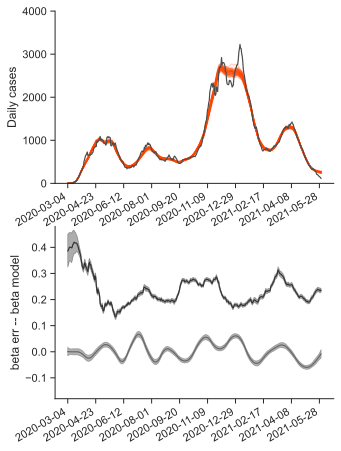

In [66]:
plot_beta(df_mhb,sim_cols_mhb)
plt.savefig("fig_behav_beta.png", bbox_inches='tight',dpi=300)

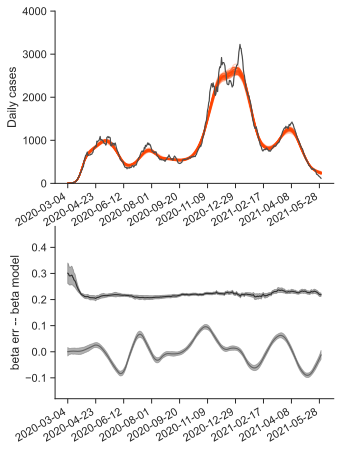

In [67]:
plot_beta(df_linear,sim_cols_linear)
plt.savefig("fig_mhlinear_beta.png", bbox_inches='tight',dpi=300)


In [68]:
def plot_theta(df):
    fig, ax = plt.subplots(figsize=[5,4],dpi=300)
    sns.lineplot(ax=ax,data=df,x="Date",y="theta",color="0.3")
    sns.despine()

    ax.yaxis.set_major_formatter(PercentFormatter(1))

    ax.fill_between(df["Date"],df["theta_lower95"],df["theta_upper95"],alpha=0.33,color="0.3")
    ax.set(ylim=(0,0.55),ylabel='reporting rate',xlabel=None)
    ax.set_xticks(ax.get_xticks()[::50]);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');


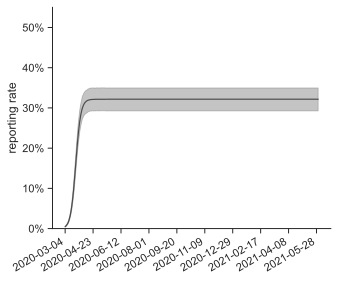

In [69]:
plot_theta(df_mhb)
plt.savefig("fig_behav_theta.png",bbox_inches='tight',dpi=300)

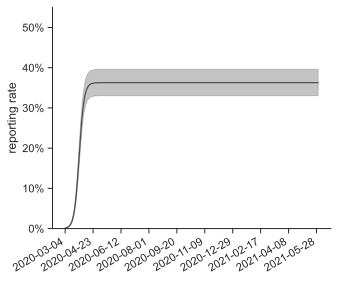

In [70]:
plot_theta(df_linear)
plt.savefig("fig_mhlinear_theta.png",bbox_inches='tight',dpi=300)

In [51]:
post = post_mhb
x = pred_daily_samp(post,MD_dict,2000)
pred_samp = x.mean(0)
obs = MD_dict['DailyCases']
resid = pred_samp - obs
## pseudo-R2 (there are better measures of this)
1.0 - np.var(resid) / np.var(obs)

DeviceArray(0.97383436, dtype=float64)

In [71]:
post = post_linear
x = pred_daily_samp(post,MD_dict,2000)
pred_samp = x.mean(0)
obs = MD_dict['DailyCases']
resid = pred_samp - obs
## pseudo-R2 (there are better measures of this)
1.0 - np.var(resid) / np.var(obs)

DeviceArray(0.9702952, dtype=float64)

In [72]:
post = post_mhb
## variation in beta explained by model (without spline)
beta_mean = post['beta'].mean(0)
beta_model_mean = post['beta_ex'].mean(0)
np.var(beta_model_mean) / np.var(beta_mean), np.var(beta_model_mean[50:]) / np.var(beta_mean[50:])

(DeviceArray(0.76590432, dtype=float64),
 DeviceArray(0.51368844, dtype=float64))

In [73]:
post = post_linear
## variation in beta explained by model (without spline)
beta_mean = post['beta'].mean(0)
beta_model_mean = post['beta_ex'].mean(0)
np.var(beta_model_mean) / np.var(beta_mean), np.var(beta_model_mean[50:]) / np.var(beta_mean[50:])

(DeviceArray(0.09731645, dtype=float64),
 DeviceArray(0.02482333, dtype=float64))

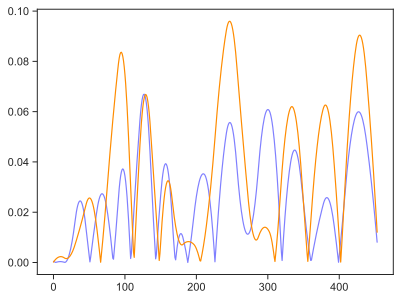

In [74]:
_, ax = plt.subplots()
ax.plot(np.abs(post_mhb['beta_err'].mean(0)), alpha=0.5, color='blue')
ax.plot(np.abs(post_linear['beta_err'].mean(0)), alpha=1.0, color='darkorange');

In [ ]:
## prediction

In [42]:
def onestep_beta_mhb(state, inputs_t):
    ## state needs to have: previous timestep's output, constant coefficients, current time, and history (for lagged effects)
    prev, coeffs, t, h_daily, hist, daily_det_rate = state
    ba,mb,hb,hmb,inv_sens,cr_init,psize,h_rate = coeffs
    ## inputs_t is a slice from time series containing ode params and/or data needed to calculate those params
    alpha, mu, gamma1, gamma2, theta, mob, hum, beta_err = inputs_t
    h_date_offset = 18
    ## use predicted daily hosp after data runs out
    cutoff = len(h_daily) - h_date_offset
    h_test = np.concatenate([h_daily, h_rate*hist[cutoff:]/daily_det_rate[cutoff:]]) 
    ma = 14
    h_test_log = np.log(1.0 + arr([*[np.nan for i in range(ma-1)], *[h_test[i:ma+i].mean() for i in range(1+len(h_test)-ma)]]))
    h_test_r = np.nanmean(arr([np.append(np.repeat(np.nan,x), (h_test_log[x:] - h_test_log[:-x]))/fl(x) for x in [3,6,9,12]]), axis=0)
    h_test_proj = np.nansum(arr([np.exp(h_test_log + fl(x) * h_test_r) for x in range(6)]), axis=0)
    p_infection = h_test_proj[h_date_offset:] / psize
    cr = np.exp(-1.0 * p_infection / inv_sens)
    delay = 20
    cr = np.concatenate([np.repeat(cr_init,delay),cr[:-delay]])
    cr_eff = cr[t]
    b_exp = cr_eff*(ba + mb*mob + hb*hum + hmb*mob*hum)
    beta = b_exp + beta_err
    p = arr([alpha, beta, mu, gamma1, gamma2, theta])
    next = odeint(SECIR_ode, prev, arr([0.,1.]), p, rtol=1e-5, atol=1e-5, mxstep=500)[1]
    ## save I in hist
    cumI = next[6]
    currI = cumI - prev[6]
    hist = hist.at[t].set(currI)
    return (next, coeffs, t+1, h_daily, hist, daily_det_rate), np.append(next,b_exp)

In [43]:
def onestep_mh1(state, inputs_t):
    ## state needs to have: previous timestep's output, constant coefficients
    prev, coeffs = state
    ba,mb,hb,hmb = coeffs
    ## inputs_t is a slice from time series containing ode params and/or data needed to calculate those params
    alpha, mu, gamma1, gamma2, theta, mob, hum, beta_err = inputs_t
    b_exp = ba + mb*mob + hb*hum + hmb*mob*hum
    beta = b_exp + beta_err
    p = arr([alpha, beta, mu, gamma1, gamma2, theta])
    next = odeint(SECIR_ode, prev, arr([0.,1.]), p, rtol=1e-5, atol=1e-5, mxstep=500)[1]
    return (next, coeffs), np.append(next,b_exp)

In [44]:
## humidity from 2015 - 2019
weather = pd.read_csv("MDWeatherStationsAH.csv",usecols=["DATE","AH","STATION","NAME"],parse_dates=["DATE"],dtype={"STATION":"Int64"})
weather15 = weather[(weather.DATE>="2015-01-01") & (weather.DATE<"2020-01-01")].copy(deep=True)
weather15["DATE"] = weather15["DATE"].astype(str)
ah_mean = weather15[["DATE","AH"]].groupby("DATE").agg("mean")
ah_mean["AH_log"] = ah_mean["AH"].map(num.log)

## humidity from 2020 - 
MD_humid_raw = read_humidity_data()

## transform to same scale
mu_r, sd_r = MD_humid_raw['AH_log'].mean(), MD_humid_raw['AH_log'].std()
ah_mean["AH_log_z"] = (ah_mean["AH_log"] - mu_r) / sd_r
ah_raw = pd.concat([ah_mean[["AH_log_z"]], MD_humid_raw[["AH_log_z"]]])

ah14 = ah_raw.rolling(14).mean()
ah14 = ah14[13:].copy(deep=True)
ah14["YEAR"] = ah14.index.map(lambda x: x[0:4]).values
ah14["DAY"] = ah14.index.map(lambda x: x[5:]).values


In [81]:
date_index[109], date_index[350]

('2020-06-21', '2021-02-17')

In [ ]:
post = post_mhb
nsamples = post['sigma'].shape[0]
h_date_offset = 18

## predicting between these timepoints:
x1 = 750
df_cases = MD_cases_all.iloc[0:x1,:]
pred_date_idx = pd.Index(df_cases["Date"])
use_mv = arr(s_mob_sq_a.loc[pred_date_idx]) - 1.0

for x0 in [50,100,150,200,250,300,350,400,450]:

    beta_err_samples = np.concatenate([post['beta_err'][:,:x0], np.zeros((nsamples,x1-x0))], axis=1)

    ## mobility constant after x0
    mv_assume = np.mean(use_mv[x0-30:x0])
    mob = np.concatenate([use_mv[:x0], np.repeat(mv_assume,x1-x0)])

    humid_in_sample = ah14.loc[pred_date_idx[0:x0]]
    break_day = ah14.loc[pred_date_idx[x0]].DAY
    ## use data from 2015 to pred start; pred range has no leap years
    ah_assume = ah14.loc[:pred_date_idx[x0], ["AH_log_z","DAY"]].iloc[:-1].groupby("DAY").agg("mean").drop("02-29")
    humid_repeat = pd.concat([ah_assume[break_day:], ah_assume[:break_day][:-1]])
    hum = np.concatenate([arr(humid_in_sample.AH_log_z), arr(humid_repeat.AH_log_z), arr(humid_repeat.AH_log_z)])[:x1]

    h_daily = arr(MD_h_daily_unsmoo['daily_hosp'].iloc[:x0+h_date_offset].values)
    hosp_rate = arr(MD_h_daily_unsmoo.rolling(3,center=True,min_periods=1).mean().loc[date_index,"daily_hosp"]) / (MD_dict['DailyCases'] / post["theta"].mean(0))
    ## to convert predicted infections to hospitalizations, assume constant hospitalization rate
    h_rate = hosp_rate[x0-30:x0].mean()

    d_res = {}
    pred_cols = []
    b_cols = []
    err_cols = []

    psize = MD_dict['Population']
    d_res['DailyCases'] = arr(df_cases["MD_DailyCases"])

    t1 = beta_err_samples.shape[1]
    samp_ids = jax.random.permutation(key(),nsamples,independent=True)[:50]
    for (col_idx,s) in enumerate(samp_ids):
        coeffs = post['ba'][s], post['mb'][s], post['hb'][s], post['hmb'][s], post["inv_sens"][s], post["cr_init"][s], psize, h_rate
        th0 = resize(post['theta'][s],t1)
        a0,mu0,g1,g2 = resize(post['alpha'][s],t1), resize(post['mu'][s],t1), resize(post['gamma1'][s],t1), resize(post['gamma2'][s],t1)
        e0,i0,c0 = post['e0'][s], post['i0'][s], post['c0'][s]
        y0 = arr([psize - (e0 + c0 + i0), e0, c0, i0, c0*0.0, c0, i0])
        init_state = (y0, coeffs, 0, h_daily, np.zeros(t1), th0)
        inputs_t = np.stack([a0, mu0, g1, g2, th0, mob, hum, beta_err_samples[s]]).T #time first
        final_state, scan_output = jax.lax.scan(onestep_beta_mhb, init_state, inputs_t)

        pred_daily = np.diff(scan_output[:,6], prepend=0)
        d_res['pred'+str(col_idx)] = pred_daily
        pred_cols.append('pred'+str(col_idx))
        d_res['beta_model'+str(col_idx)] = scan_output[:,7]
        b_cols.append('beta_model'+str(col_idx))
        d_res['beta_err'+str(col_idx)] = beta_err_samples[s]
        err_cols.append('beta_err'+str(col_idx))

    df = pd.DataFrame(d_res,index=pred_date_idx)

    df['mean_pred'] = df[pred_cols].mean(axis=1)
    df['mean_beta_model'] = df[b_cols].mean(axis=1)
    df['mean_beta_err'] = df[err_cols].mean(axis=1)
    df["Date"] = df.index

    fig, ax = plt.subplots(2,1,figsize=[5,7],dpi=300)
    for c in pred_cols:
        ax[0].plot(df[c], color="orangered", alpha=0.25)

    sns.lineplot(ax=ax[0],data=df,x="Date",y="DailyCases",color="0.3")
    sns.despine()

    for c in b_cols:
            ax[1].plot(df["Date"], df[c], alpha=0.2,color='0.2')

    for c in err_cols:
            ax[1].plot(df["Date"], df[c], alpha=0.2,color='0.4')

    ax[0].set(ylim=(0,4000), xlabel=None, ylabel='daily cases')
    ax[1].set(ylim=(-0.18,0.58), xlabel=None, ylabel='beta err -- beta model')
    fig.subplots_adjust(hspace=0.25)

    for x in ax:
        x.set_xticks(x.get_xticks()[::100]);
        x.set_xticklabels(x.get_xticklabels(), rotation=30, horizontalalignment='right');

    df.to_csv("from"+str(x0)+"_behav.csv",float_format="%.6g")
    plt.savefig("from"+str(x0)+"_behav.png", bbox_inches='tight',dpi=300)



In [ ]:
post = post_linear
nsamples = post['sigma'].shape[0]

## predicting between these timepoints:
x1 = 750
df_cases = MD_cases_all.iloc[0:x1,:]
pred_date_idx = pd.Index(df_cases["Date"])
use_mv = arr(s_mob_sq_a.loc[pred_date_idx]) - 1.0

for x0 in [50,100,150,200,250,300,350,400,450]:

    beta_err_samples = np.concatenate([post['beta_err'][:,:x0], np.zeros((nsamples,x1-x0))], axis=1)

    ## mobility constant after x0
    mv_assume = np.mean(use_mv[x0-30:x0])
    mob = np.concatenate([use_mv[:x0], np.repeat(mv_assume,x1-x0)])

    humid_in_sample = ah14.loc[pred_date_idx[0:x0]]
    break_day = ah14.loc[pred_date_idx[x0]].DAY
    ## use data from 2015 to pred start; pred range has no leap years
    ah_assume = ah14.loc[:pred_date_idx[x0], ["AH_log_z","DAY"]].iloc[:-1].groupby("DAY").agg("mean").drop("02-29")
    humid_repeat = pd.concat([ah_assume[break_day:], ah_assume[:break_day][:-1]])
    hum = np.concatenate([arr(humid_in_sample.AH_log_z), arr(humid_repeat.AH_log_z), arr(humid_repeat.AH_log_z)])[:x1]

    d_res = {}
    pred_cols = []
    b_cols = []
    err_cols = []

    psize = MD_dict['Population']
    d_res['DailyCases'] = arr(df_cases["MD_DailyCases"])

    t1 = beta_err_samples.shape[1]
    samp_ids = jax.random.permutation(key(),nsamples,independent=True)[:50]
    for (col_idx,s) in enumerate(samp_ids):
        coeffs = post['ba'][s], post['mb'][s], post['hb'][s], post['hmb'][s]
        th0 = resize(post['theta'][s],t1)
        a0,mu0,g1,g2 = resize(post['alpha'][s],t1), resize(post['mu'][s],t1), resize(post['gamma1'][s],t1), resize(post['gamma2'][s],t1)
        e0,i0,c0 = post['e0'][s], post['i0'][s], post['c0'][s]
        y0 = arr([psize - (e0 + c0 + i0), e0, c0, i0, c0*0.0, c0, i0])
        init_state = (y0, coeffs)
        inputs_t = np.stack([a0, mu0, g1, g2, th0, mob, hum, beta_err_samples[s]]).T #time first
        final_state, scan_output = jax.lax.scan(onestep_mh1, init_state, inputs_t)

        pred_daily = np.diff(scan_output[:,6], prepend=0)
        d_res['pred'+str(col_idx)] = pred_daily
        pred_cols.append('pred'+str(col_idx))
        d_res['beta_model'+str(col_idx)] = scan_output[:,7]
        b_cols.append('beta_model'+str(col_idx))
        d_res['beta_err'+str(col_idx)] = beta_err_samples[s]
        err_cols.append('beta_err'+str(col_idx))

    df = pd.DataFrame(d_res,index=pred_date_idx)

    df['mean_pred'] = df[pred_cols].mean(axis=1)
    df['mean_beta_model'] = df[b_cols].mean(axis=1)
    df['mean_beta_err'] = df[err_cols].mean(axis=1)
    df["Date"] = df.index

    fig, ax = plt.subplots(2,1,figsize=[5,7],dpi=300)
    for c in pred_cols:
        ax[0].plot(df[c], color="orangered", alpha=0.25)

    sns.lineplot(ax=ax[0],data=df,x="Date",y="DailyCases",color="0.3")
    sns.despine()

    for c in b_cols:
            ax[1].plot(df["Date"], df[c], alpha=0.2,color='0.2')

    for c in err_cols:
            ax[1].plot(df["Date"], df[c], alpha=0.2,color='0.4')

    ax[0].set(ylim=(0,4000), xlabel=None, ylabel='daily cases')
    ax[1].set(ylim=(-0.18,0.58), xlabel=None, ylabel='beta err -- beta model')
    fig.subplots_adjust(hspace=0.25)

    for x in ax:
        x.set_xticks(x.get_xticks()[::100]);
        x.set_xticklabels(x.get_xticklabels(), rotation=30, horizontalalignment='right');

    df.to_csv("from"+str(x0)+"_linear.csv", float_format="%.6g")
    plt.savefig("from"+str(x0)+"_linear.png", bbox_inches='tight',dpi=300)



In [ ]:
pred_total_daily = pred_daily_samp(post, MD_dict, 5000, True)

In [ ]:
df["inf_total"] = pred_total_daily.mean(0)
ci = hpdi(pred_total_daily)
df["inf_total_L"] = ci[0]
df["inf_total_H"] = ci[1]

In [ ]:
fig, ax = plt.subplots(figsize=[5,4],dpi=300)
sns.lineplot(ax=ax,data=df,x="Date",y="inf_total",color="0.3")
sns.lineplot(ax=ax,data=df,x="Date",y="DailyCases",color="orangered")
sns.despine()

ax.fill_between(df["Date"],df["inf_total_L"],df["inf_total_H"],alpha=0.33,color="0.3")
ax.set(ylabel='total daily infected',xlabel=None)
ax.set_xticks(ax.get_xticks()[::50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

#plt.savefig("wrev sero_total_infected.png",bbox_inches='tight',dpi=300)


In [ ]:
daily_deaths = arr(MD_deaths.loc['2020-03-04':,'daily_deaths'])

In [ ]:

nb_r = 5.6
nb_p = 0.2857
xlen = daily_deaths.shape[0]
p_dist = stats.nbinom.pmf(np.arange(xlen), nb_r, nb_p).round(6)

future_deaths = arr([np.nansum(daily_deaths * p_dist), 
    *[np.nansum(daily_deaths[i:] * p_dist[:-i]) for i in range(1,xlen-60)]])

future_deaths = future_deaths[:MD_dict['tdom'].shape[0]]


In [ ]:
prob_fatality = future_deaths / pred_total_daily
ci = hpdi(prob_fatality)

In [ ]:
df = df.join(pd.DataFrame({"prob_fatality":prob_fatality.mean(0), "prob_fatality_L":ci[0], "prob_fatality_H":ci[1]}))

In [ ]:

## very noisy at beginning
df_plot = df.iloc[18:-5,:]

fig, ax = plt.subplots(figsize=[4,6],dpi=300)
sns.lineplot(ax=ax,data=df_plot,x="Date",y="prob_fatality",color="0.3")
sns.despine()

ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.fill_between(df_plot["Date"],df_plot["prob_fatality_L"],df_plot["prob_fatality_H"],alpha=0.33,color="0.3")
ax.set(ylabel='infection fatality rate',xlabel=None,ylim=(-0.002,0.05))
ax.set_yticks(ax.get_yticks()[1::1]);
ax.set_xticks(ax.get_xticks()[::60]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

#plt.savefig("wrev prob infection_fatality.png",bbox_inches='tight',dpi=300)


In [ ]:
df_plot[["Date","prob_fatality"]].iloc[163:,:]

In [ ]:
ifr_after_sep = prob_fatality[:,163+18:-5].mean(1)

In [ ]:
print(100 * ifr_after_sep.mean(), "%")
print(100 * hpdi(ifr_after_sep,prob=0.95), "%")

In [ ]:
pd.read_csv("mhlinear_summary.csv",usecols=["mean","sd","hdi_3%","hdi_97%","ess_bulk","r_hat"]).to_csv("mhlinear_formatted.csv",float_format="%.5g")

In [10]:
pd.read_csv("behav_summary.csv",usecols=["mean","sd","hdi_3%","hdi_97%","ess_bulk","r_hat"]).to_csv("behav_formatted.csv",float_format="%.5g")